In [1]:
import sys

ssh = True
if ssh:
    data_folder = "/home/gperri-ext/master_thesis/data//"
    sys.path.append('/home/gperri-ext/master_thesis/')
else:
    data_folder = r"C:\Users\Giova\thesis\master_thesis\data//"
    sys.path.append(r"C:\Users\Giova\thesis\master_thesis//")



import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() # for shap

import keras_tuner as kt
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, ConvLSTM1D, TimeDistributed, Flatten, Dropout, RepeatVector, Activation, ReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


from modules.evaluation_func import single_timeseries_evaluation_metrics_func, evaluate_and_plot_timeseries, NMAE_error
from modules.visualization import plot_model_loss, plot_error_metrics_barchart, plot_model_rmse_and_loss
from modules.windowing_data import multivariate_data, prepare_dataset_for_training
from modules.temp_features import make_yearly_dataset, create_cyclic_features, transform_time_features
from modules.daily_errors import errors_on_rows, visualize_errors_with_timestamps, filter_errors_at_midnight, calculate_mae_errors, calculate_mape_errors, calculate_rmse_errors, calculate_nmae_errors


from tensorflow import keras, config
from keras import layers

physical_devices = config.list_physical_devices('GPU') 
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

%matplotlib inline


2024-03-12 14:26:41.884025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# # PYTHON NON RICARICA AUTOMATICAMENTE I MODULI

# from importlib import reload
# import modules.evaluation_func

# # Ricarica il modulo
# reload(modules.evaluation_func)



### Importing data

In [3]:
file_name = "every_zone.csv"

try:
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    
except FileNotFoundError:
    print("File not found. Please provide the correct path to the data folder.")

In [4]:
df.set_index('Time_data', inplace=True)
df.index = pd.to_datetime(df.index)

### Adding renewable energy data

In [5]:
df_actualgeneration = pd.read_csv(sys.path[-1] + "/2024_RENEW_IPEX/Italy_ActualGeneration.csv")
df_dayaheadsolar = pd.read_csv(sys.path[-1] + "/2024_RENEW_IPEX/Italy_DayAheadSolarGeneration.csv")
df_dayaheadwind = pd.read_csv(sys.path[-1] + "/2024_RENEW_IPEX/Italy_DayAheadWindOnshoreGeneration.csv")

In [6]:
df_dayaheadsolar['Time_data'] = df_dayaheadsolar['date'].apply(lambda t: pd.Timestamp(t).normalize().tz_localize('CET').tz_convert('UTC')) + \
                    df_dayaheadsolar['position'].apply(lambda h: pd.Timedelta(hours=h))

df_dayaheadsolar.set_index('Time_data', inplace=True)

In [7]:
df_dayaheadwind['Time_data'] = df_dayaheadwind['date'].apply(lambda t: pd.Timestamp(t).normalize().tz_localize('CET').tz_convert('UTC')) + \
                    df_dayaheadwind['position'].apply(lambda h: pd.Timedelta(hours=h))

df_dayaheadwind.set_index('Time_data', inplace=True)

In [8]:
df_dayaheadsolar = df_dayaheadsolar.sort_index()
df_dayaheadwind = df_dayaheadwind.sort_index()


In [9]:
# df_SP1['Time_data'] = df_SP1['ts'].apply(lambda t: pd.Timestamp(t).normalize().tz_localize('CET').tz_convert('UTC'))

# df_SP1.set_index('Time_data', inplace=True)

# df_WP1['Time_data'] = df_WP1['date'].apply(lambda t: pd.Timestamp(t).normalize().tz_localize('CET').tz_convert('UTC')) + \
#                     df_WP1['position'].apply(lambda h: pd.Timedelta(hours=h))

# df_WP1.set_index('Time_data', inplace=True)


# df_SP1.drop(columns=['model', 'generation_ts'], inplace=True)
# df_WP1.drop(columns=['model', 'generation_ts'], inplace=True)
# df_WP1 = df_WP1.pivot_table(index='Time_data', columns='zone', values='production_wind')
# df_SP1 = df_SP1.pivot_table(index='Time_data', columns='zone', values='production_solar')

In [10]:
df_dayaheadsolar = df_dayaheadsolar.pivot_table(index='Time_data', columns='in_Name', values='quantity')
df_dayaheadwind = df_dayaheadwind.pivot_table(index='Time_data', columns='in_Name', values='quantity')

df_dayaheadsolar = df_dayaheadsolar.iloc[1:]
df_dayaheadwind = df_dayaheadwind.iloc[1:]


In [11]:
df_dayaheadwind['TOTAL'] = df_dayaheadwind.iloc[:, 1:].sum(axis=1)
df_dayaheadsolar['TOTAL'] = df_dayaheadsolar.iloc[:, 1:].sum(axis=1)

In [12]:
# df_dayaheadsolar.index = pd.to_datetime(df_dayaheadsolar.index)
# df_dayaheadwind.index = pd.to_datetime(df_dayaheadwind.index)

In [13]:
df_dayaheadwind = df_dayaheadwind.add_suffix('-WIND')
df_dayaheadsolar = df_dayaheadsolar.add_suffix('-SOLAR')

df_dayaheadrenewables = pd.concat([df_dayaheadwind, df_dayaheadsolar], axis=1)

In [14]:
df_dayaheadrenewables = df_dayaheadrenewables[df_dayaheadrenewables.index.isin(df.index)]

In [15]:
df_total = pd.concat([df, df_dayaheadrenewables], axis=1)


In [16]:
df_total = df_total.drop(columns=['PUN_d+1-7', 'PUN_d+1-14', 'GAS_d+1-7', 'Total_Load_d+1-7'])


In [17]:
df_total.fillna(0, inplace=True)

### Creating zone data

In [18]:
df_CNOR = df_total[['CNOR', 'CNOR_load', 'IT-CENTRE_NORTH-SOLAR', 'IT-CENTRE_NORTH-WIND', 'GAS', 'Ora', 'GiornoSettimana', 'holiday']]
df_CSUD = df_total[['CSUD', 'CSUD_load', 'IT-CENTRE_SOUTH-SOLAR', 'IT-CENTRE_SOUTH-WIND', 'GAS', 'Ora', 'GiornoSettimana', 'holiday']]
df_NORD = df_total[['NORD', 'NORD_load', 'IT-NORTH-SOLAR', 'IT-NORTH-WIND', 'GAS', 'Ora', 'GiornoSettimana', 'holiday']]
df_SARD = df_total[['SARD', 'SARD_load', 'IT-SARDINIA-SOLAR', 'IT-SARDINIA-WIND', 'GAS', 'Ora', 'GiornoSettimana', 'holiday']]
df_SICI = df_total[['SICI', 'SICI_load', 'IT-SICILY-SOLAR', 'IT-SICILY-WIND', 'GAS', 'Ora', 'GiornoSettimana', 'holiday']]
df_SUD = df_total[['SUD', 'SUD_load', 'IT-SOUTH-SOLAR', 'IT-SOUTH-WIND', 'GAS', 'Ora', 'GiornoSettimana', 'holiday']]
df_Italia = df_total[['PUN', 'Italia_load', 'TOTAL-SOLAR', 'TOTAL-WIND', 'GAS', 'Ora', 'GiornoSettimana', 'holiday']]


In [19]:
# Shift delle colonne CNOR, CSUD, NORD, SARD, SICI, SUD, PUN di 1 giorno 
cnor = df_CNOR['CNOR'].shift(1, freq=pd.DateOffset(days=-1))
csud = df_CSUD['CSUD'].shift(1, freq=pd.DateOffset(days=-1))
nord = df_NORD['NORD'].shift(1, freq=pd.DateOffset(days=-1))
sard = df_SARD['SARD'].shift(1, freq=pd.DateOffset(days=-1))
sici = df_SICI['SICI'].shift(1, freq=pd.DateOffset(days=-1))
sud = df_SUD['SUD'].shift(1, freq=pd.DateOffset(days=-1))
pun = df_Italia['PUN'].shift(1, freq=pd.DateOffset(days=-1))

df_CNOR['CNOR_d+1-7'] = cnor.shift(1, freq=pd.DateOffset(weeks=1))
df_CSUD['CSUD_d+1-7'] = csud.shift(1, freq=pd.DateOffset(weeks=1))
df_NORD['NORD_d+1-7'] = nord.shift(1, freq=pd.DateOffset(weeks=1))
df_SARD['SARD_d+1-7'] = sard.shift(1, freq=pd.DateOffset(weeks=1))
df_SICI['SICI_d+1-7'] = sici.shift(1, freq=pd.DateOffset(weeks=1))
df_SUD['SUD_d+1-7'] = sud.shift(1, freq=pd.DateOffset(weeks=1))
df_Italia['PUN_d+1-7'] = pun.shift(1, freq=pd.DateOffset(weeks=1))


/tmp/ipykernel_2280321/4151938289.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CNOR['CNOR_d+1-7'] = cnor.shift(1, freq=pd.DateOffset(weeks=1))
/tmp/ipykernel_2280321/4151938289.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CSUD['CSUD_d+1-7'] = csud.shift(1, freq=pd.DateOffset(weeks=1))
/tmp/ipykernel_2280321/4151938289.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [20]:
df_CNOR.dropna(inplace=True)
df_CSUD.dropna(inplace=True)
df_NORD.dropna(inplace=True)
df_SARD.dropna(inplace=True)
df_SICI.dropna(inplace=True)
df_SUD.dropna(inplace=True)
df_Italia.dropna(inplace=True)


/tmp/ipykernel_2280321/1404665668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CNOR.dropna(inplace=True)
/tmp/ipykernel_2280321/1404665668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CSUD.dropna(inplace=True)
/tmp/ipykernel_2280321/1404665668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NORD.dropna(inplace=True)
/tmp/ipykernel_2280321/1404665668.py:4: SettingWithCopyWarning: 
A value is trying to be set o

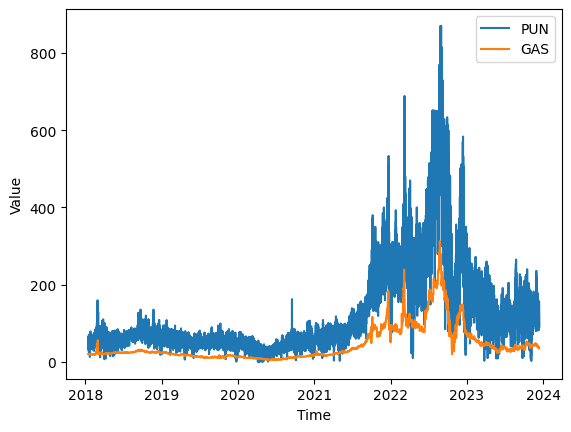

In [21]:
plt.plot(df['PUN'], label='PUN')
plt.plot(df['GAS'], label='GAS')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [22]:
df_SARD = create_cyclic_features(df_SARD)

/home/gperri-ext/master_thesis/modules/temp_features.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_input.loc[:, 'hour_sin'], dataset_input.loc[:, 'hour_cos'] = transform_time_features(dataset_input['Ora'], 24)
/home/gperri-ext/master_thesis/modules/temp_features.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_input.loc[:, 'hour_sin'], dataset_input.loc[:, 'hour_cos'] = transform_time_features(dataset_input['Ora'], 24)
/home/gperri-ext/master_thesis/modules/temp_features.py:17: Se

In [23]:
df_normalized = df.copy()

scaler = MinMaxScaler()
df_normalized[['PUN', 'GAS']] = scaler.fit_transform(df[['PUN', 'GAS']])

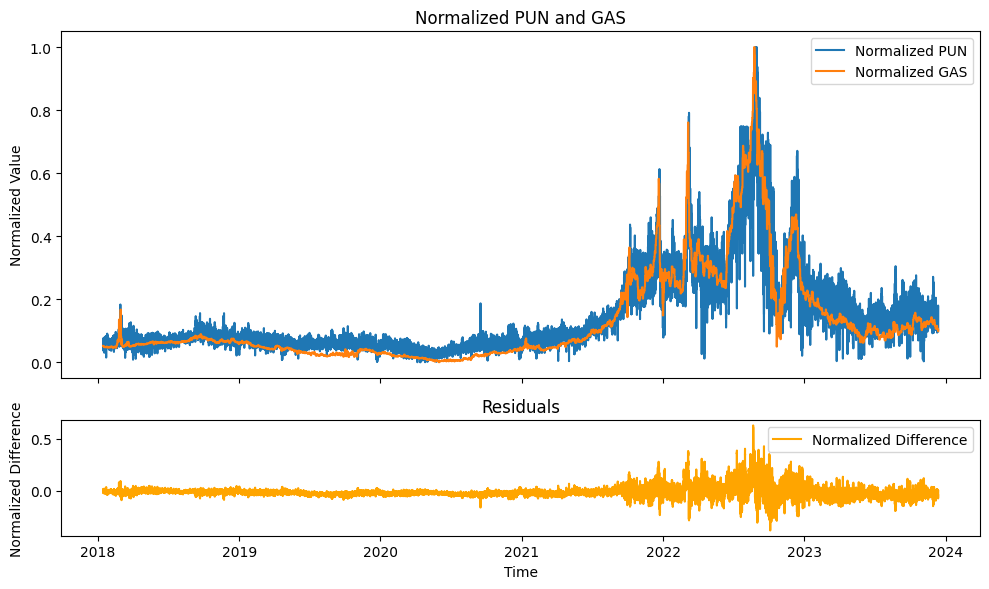

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

axes[0].plot(df.index, df_normalized['PUN'], label='Normalized PUN')
axes[0].plot(df.index, df_normalized['GAS'], label='Normalized GAS')
axes[0].legend()
axes[0].set_ylabel('Normalized Value')
axes[0].set_title('Normalized PUN and GAS')

# Calcolo e grafico delle differenze normalizzate
difference = df_normalized['GAS'] - df_normalized['PUN']
axes[1].plot(df.index, difference, label='Normalized Difference', color='orange')
axes[1].legend()
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Normalized Difference')
axes[1].set_title('Residuals')

plt.tight_layout()
plt.show()

In [25]:
window_size = 7  # Esempio di finestra mobile di 7 giorni
df_normalized['GAS_avg'] = df_normalized['GAS'].rolling(window=window_size).mean()
df_normalized['PUN_adjusted'] = df_normalized['PUN'] - df_normalized['GAS_avg']

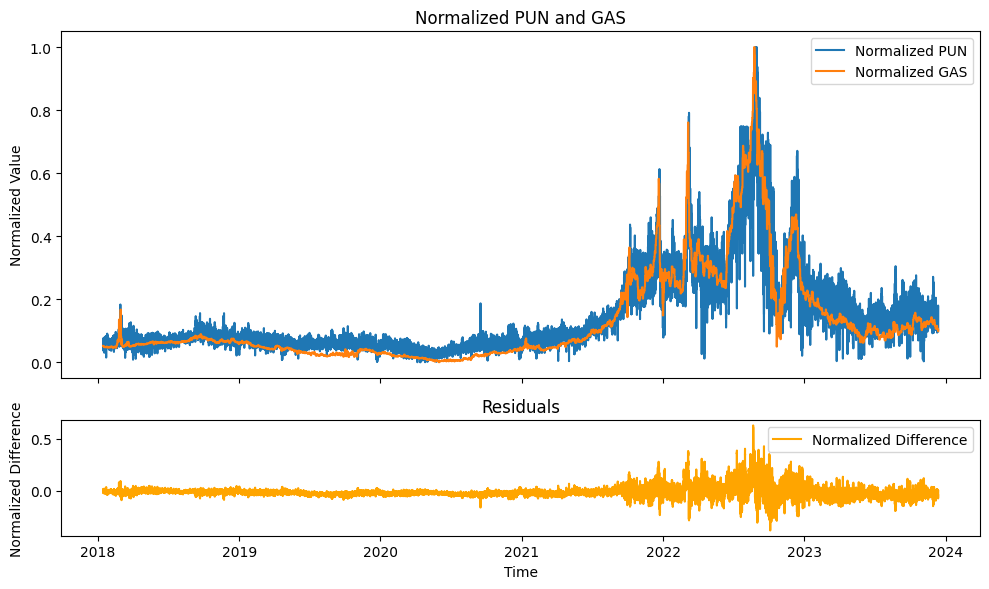

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

axes[0].plot(df.index, df_normalized['PUN'], label='Normalized PUN')
axes[0].plot(df.index, df_normalized['GAS'], label='Normalized GAS')
# axes[0].plot(df.index, df_normalized['GAS_avg'], label='Normalized GAS average')
axes[0].legend()
axes[0].set_ylabel('Normalized Value')
axes[0].set_title('Normalized PUN and GAS')

# Calcolo e grafico delle differenze normalizzate
difference = df_normalized['GAS'] - df_normalized['PUN']
difference_avg = df_normalized['GAS_avg'] - df_normalized['PUN']
axes[1].plot(df.index, difference, label='Normalized Difference', color='orange')
# axes[1].plot(df.index, difference_avg, label='Normalized Difference with GAS average', color='green', linestyle='--')
axes[1].legend()
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Normalized Difference')
axes[1].set_title('Residuals')

plt.tight_layout()
plt.show()

In [27]:
# differenza percentuale tra PUN e GAS
df_normalized['PUN_GAS_percent_diff'] = (df_normalized['PUN'] - df_normalized['GAS']) / df_normalized['GAS'] * 100

# variazione percentuale giornaliera 
df_normalized['PUN_daily_percent_change'] = df_normalized['PUN'].pct_change(periods=24*7) * 100

# Calcola la differenza assoluta tra il prezzo PUN e il prezzo del gas
df_normalized['PUN_GAS_abs_diff'] = df_normalized['PUN'] - df_normalized['GAS']

# Calcola la media mobile della differenza percentuale
window_size = 7*24
df_normalized['PUN_GAS_percent_diff_avg'] = (df_normalized['PUN'] - df_normalized['GAS']) / df_normalized['GAS'] * 100
df_normalized['PUN_GAS_percent_diff_avg'] = df_normalized['PUN_GAS_percent_diff_avg'].rolling(window=window_size).mean()


In [28]:
df_normalized['PUN_daily_percent_change']

Time_data
2018-01-14 00:00:00+00:00          NaN
2018-01-14 01:00:00+00:00          NaN
2018-01-14 02:00:00+00:00          NaN
2018-01-14 03:00:00+00:00          NaN
2018-01-14 04:00:00+00:00          NaN
                               ...    
2023-12-12 20:00:00+00:00    -8.295110
2023-12-12 21:00:00+00:00    -7.720820
2023-12-12 22:00:00+00:00    -8.803866
2023-12-12 23:00:00+00:00   -16.065858
2023-12-13 00:00:00+00:00    -8.312958
Name: PUN_daily_percent_change, Length: 51817, dtype: float64

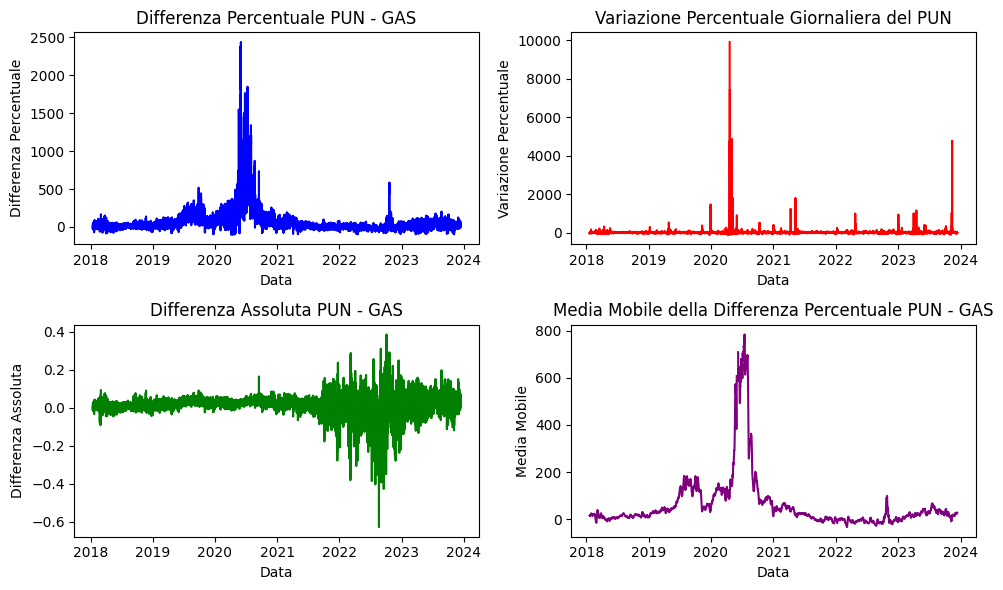

In [29]:
plt.figure(figsize=(10, 6))

# Plot della differenza percentuale tra PUN e GAS
plt.subplot(2, 2, 1)
plt.plot(df_normalized.index, df_normalized['PUN_GAS_percent_diff'], color='blue')
plt.title('Differenza Percentuale PUN - GAS')
plt.xlabel('Data')
plt.ylabel('Differenza Percentuale')

# Plot della variazione percentuale giornaliera del prezzo del gas
plt.subplot(2, 2, 2)
plt.plot(df_normalized.index, df_normalized['PUN_daily_percent_change'], color='red')
plt.title('Variazione Percentuale Giornaliera del PUN')
plt.xlabel('Data')
plt.ylabel('Variazione Percentuale')

# Plot della differenza assoluta tra PUN e GAS
plt.subplot(2, 2, 3)
plt.plot(df_normalized.index, df_normalized['PUN_GAS_abs_diff'], color='green')
plt.title('Differenza Assoluta PUN - GAS')
plt.xlabel('Data')
plt.ylabel('Differenza Assoluta')

# Plot della media mobile della differenza percentuale
plt.subplot(2, 2, 4)
plt.plot(df_normalized.index, df_normalized['PUN_GAS_percent_diff_avg'], color='purple')
plt.title('Media Mobile della Differenza Percentuale PUN - GAS')
plt.xlabel('Data')
plt.ylabel('Media Mobile')

plt.tight_layout()
plt.show()


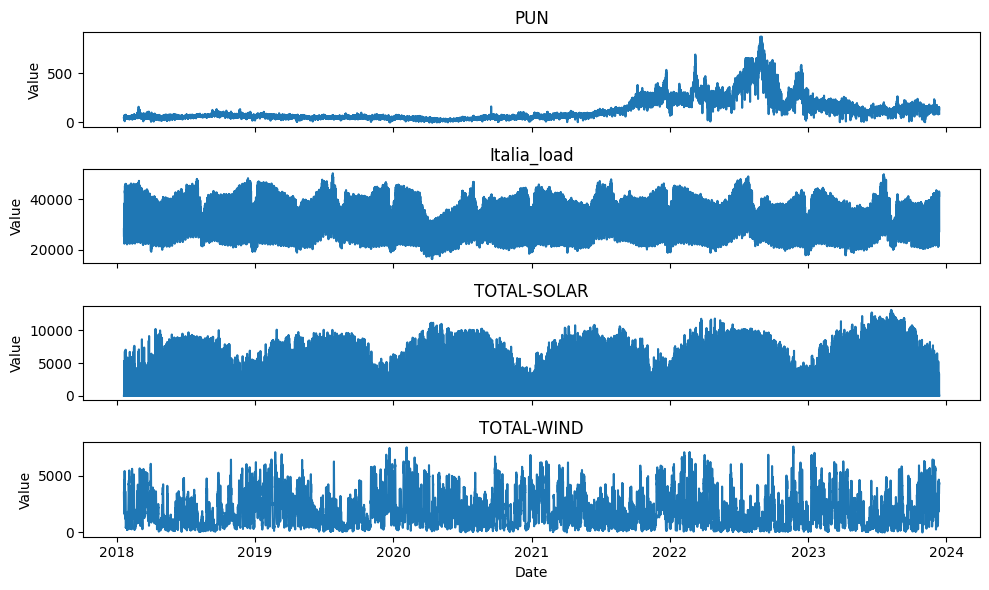

In [30]:
fig, axs = plt.subplots(4, figsize=(10, 6))

# PUN plot
axs[0].plot(df_Italia.index, df_Italia['PUN'])
axs[0].set_title('PUN')

# Italia_load plot
axs[1].plot(df_Italia.index, df_Italia['Italia_load'])
axs[1].set_title('Italia_load')

# TOTAL-SOLAR plot
axs[2].plot(df_Italia.index, df_Italia['TOTAL-SOLAR'])
axs[2].set_title('TOTAL-SOLAR')

# TOTAL-WIND plot
axs[3].plot(df_Italia.index, df_Italia['TOTAL-WIND'])
axs[3].set_title('TOTAL-WIND')

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.tight_layout()
plt.show()

In [31]:
scaler = MinMaxScaler()

# Fit and transform the data
df_Italia_normalized = pd.DataFrame(scaler.fit_transform(df_Italia), columns=df_Italia.columns, index=df_Italia.index)


In [32]:
df_Italia_normalized['PUN_minus_GAS'] = df_Italia_normalized['PUN'] - df_Italia_normalized['GAS']

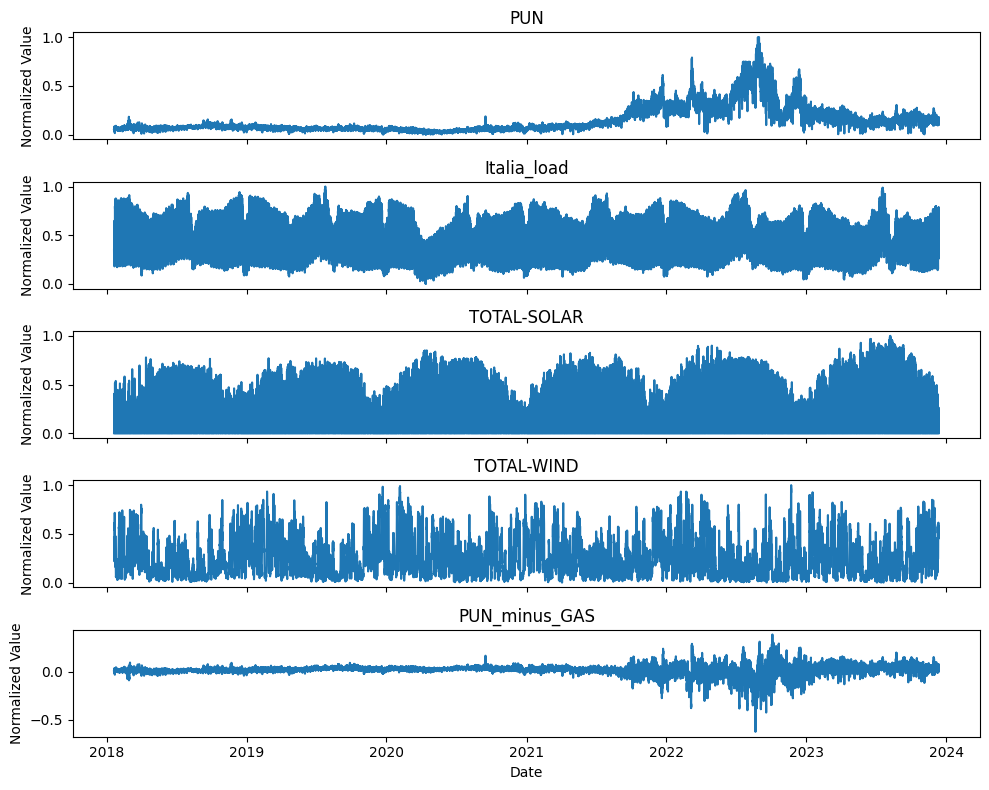

In [33]:
fig, axs = plt.subplots(5, figsize=(10, 8))

# PUN plot
axs[0].plot(df_Italia_normalized.index, df_Italia_normalized['PUN'])
axs[0].set_title('PUN')

# Italia_load plot
axs[1].plot(df_Italia_normalized.index, df_Italia_normalized['Italia_load'])
axs[1].set_title('Italia_load')

# TOTAL-SOLAR plot
axs[2].plot(df_Italia_normalized.index, df_Italia_normalized['TOTAL-SOLAR'])
axs[2].set_title('TOTAL-SOLAR')

# TOTAL-WIND plot
axs[3].plot(df_Italia_normalized.index, df_Italia_normalized['TOTAL-WIND'])
axs[3].set_title('TOTAL-WIND')

# PUN_minus_GAS plot
axs[4].plot(df_Italia_normalized.index, df_Italia_normalized['PUN_minus_GAS'])
axs[4].set_title('PUN_minus_GAS')

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Normalized Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.tight_layout()
plt.show()

In [34]:
df_SUD.head()

,SUD,SUD_load,IT-SOUTH-SOLAR,IT-SOUTH-WIND,GAS,Ora,GiornoSettimana,holiday,SUD_d+1-7
Time_data,,,,,,,,,
2018-01-20 00:00:00+00:00,43.03,2288.47,0.0,1898.0,19.5,1,5,1,42.04
2018-01-20 01:00:00+00:00,42.58,2132.30,0.0,1739.0,19.5,2,5,1,36.07
2018-01-20 02:00:00+00:00,41.72,2050.12,0.0,1534.0,19.5,3,5,1,35.02
2018-01-20 03:00:00+00:00,41.77,2017.42,0.0,1337.0,19.5,4,5,1,33.18
2018-01-20 04:00:00+00:00,41.31,2010.34,0.0,1168.0,19.5,5,5,1,32.81


In [35]:
# df_NORD.to_csv('df_NORD.csv', index=True)
# df_SUD.to_csv('df_SUD.csv', index=True)
# df_SICI.to_csv('df_SICI.csv', index=True)
# df_SARD.to_csv('df_SARD.csv', index=True)
# df_CSUD.to_csv('df_CSUD.csv', index=True)
# df_CNOR.to_csv('df_CNOR.csv', index=True)
# df_Italia.to_csv('df_Italia.csv', index=True)



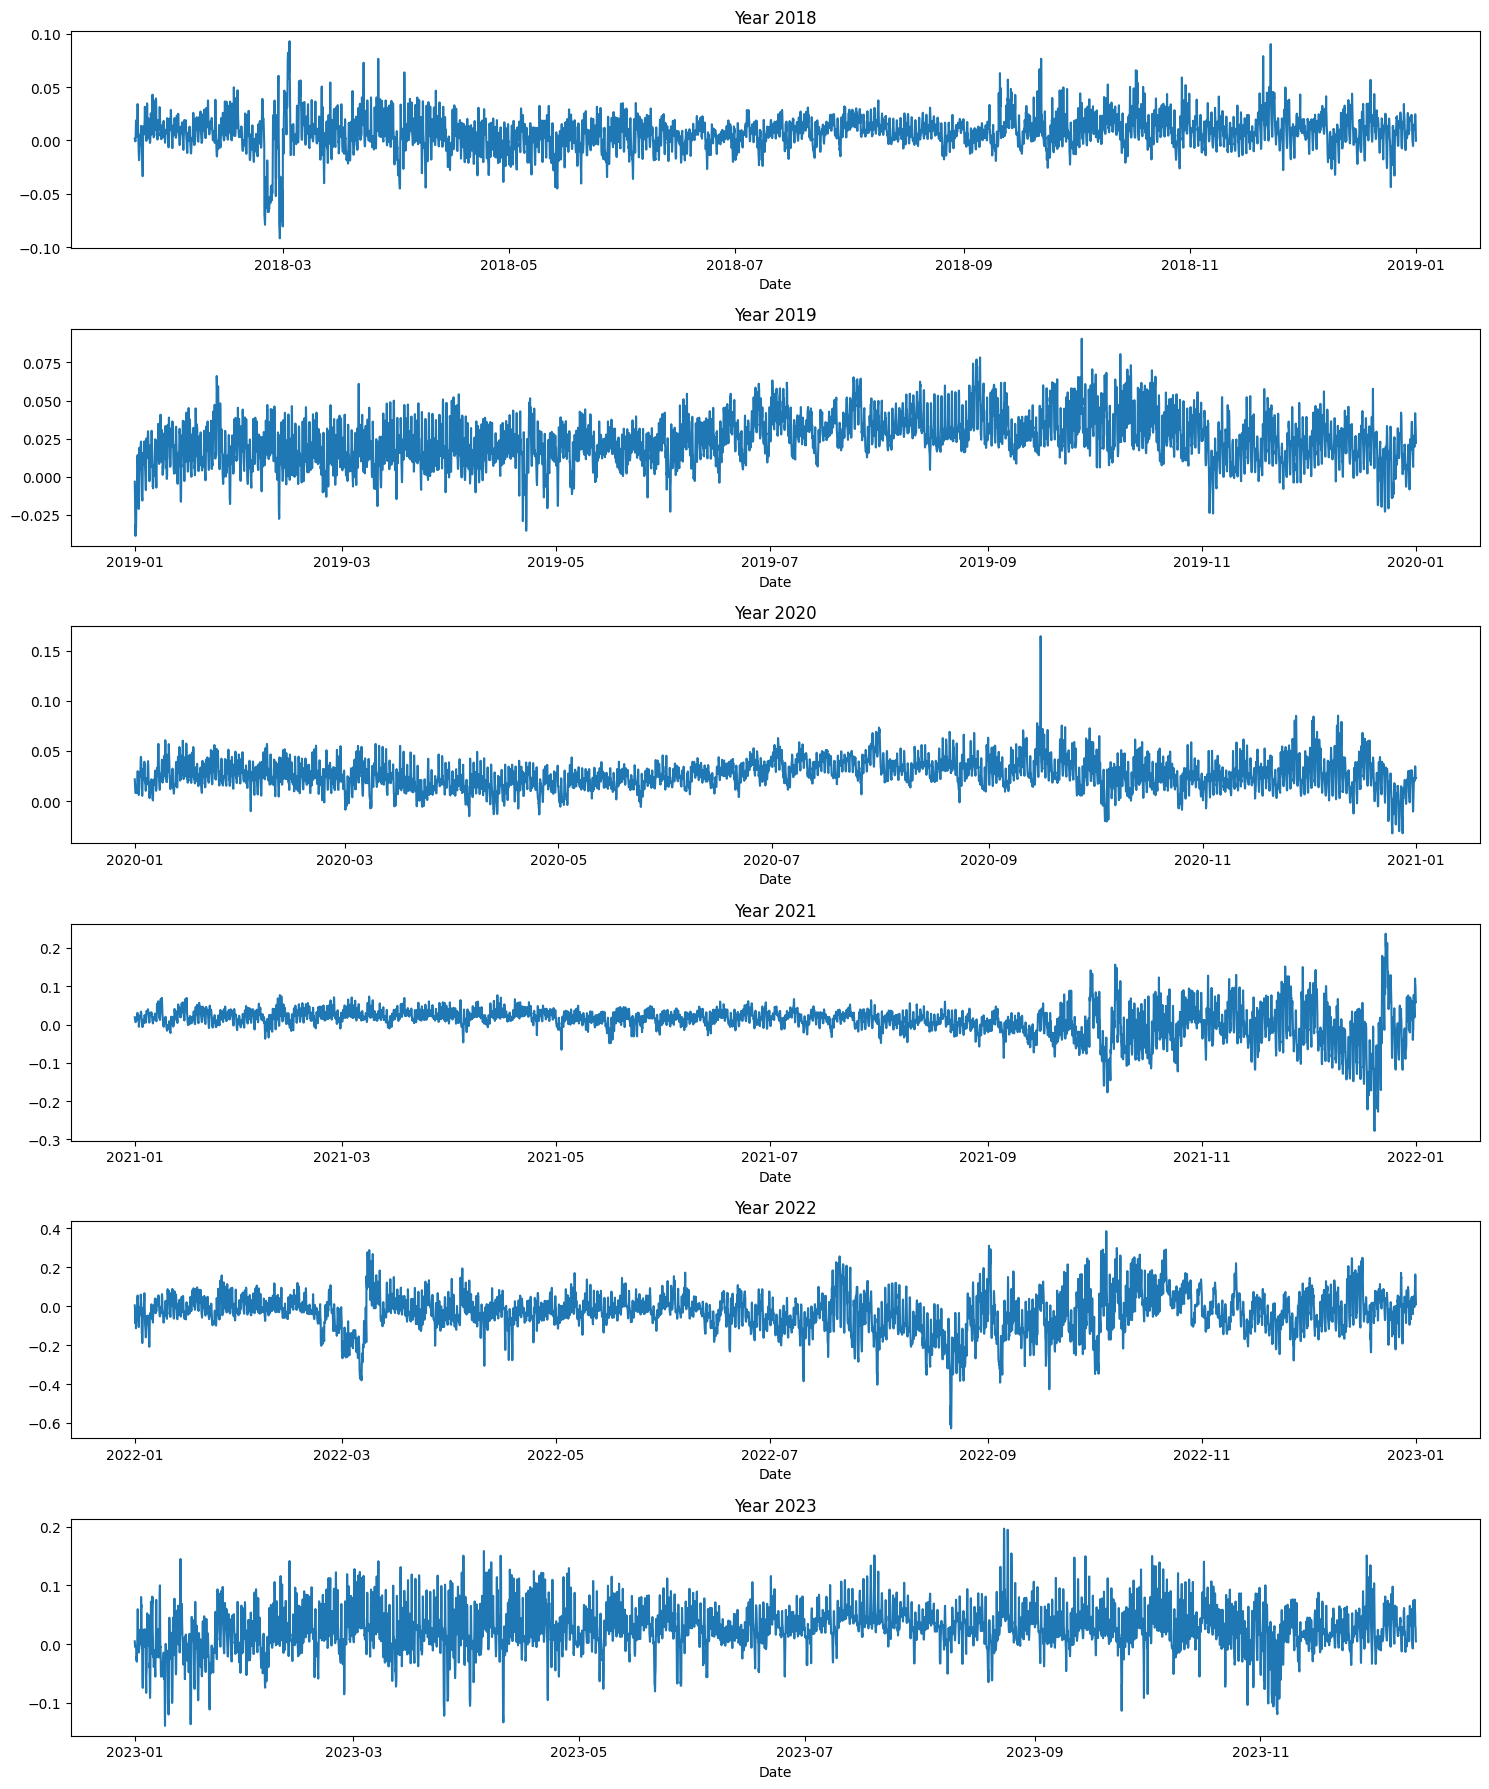

In [36]:
import matplotlib.pyplot as plt

# Estrai gli anni unici presenti nel dataframe
unique_years = df_Italia_normalized['PUN_minus_GAS'].index.year.unique()

# Imposta la dimensione del subplot in base al numero di anni
num_years = len(unique_years)
# Crea il subplot
fig, axs = plt.subplots(num_years, 1, figsize=(15, 6*3))

# Itera sugli anni e crea un subplot per ciascun anno
for i, year in enumerate(unique_years):
    # Seleziona i dati relativi all'anno corrente
    data_year = df_Italia_normalized['PUN_minus_GAS'][df_Italia_normalized.index.year == year]
    # Plot
    axs[i].plot(data_year.index, data_year.values)
    axs[i].set_title(f'Year {year}')
    axs[i].set_xlabel('Date')

# Aggiusta la sovrapposizione tra i subplot
plt.tight_layout()

# Mostra il plot
plt.show()


In [37]:
df_2018 = make_yearly_dataset(df_Italia_normalized, 2018, 2018)
df_2019 = make_yearly_dataset(df_Italia_normalized, 2019, 2019)
df_2020 = make_yearly_dataset(df_Italia_normalized, 2020, 2020)
df_2021 = make_yearly_dataset(df_Italia_normalized, 2021, 2021)
df_2022 = make_yearly_dataset(df_Italia_normalized, 2022, 2022)
df_2023 = make_yearly_dataset(df_Italia_normalized, 2023, 2023)

### lstm

In [38]:
dataset_input = df_Italia_normalized

In [39]:
dataset_input.head()

,PUN,Italia_load,TOTAL-SOLAR,TOTAL-WIND,GAS,Ora,GiornoSettimana,holiday,PUN_d+1-7,PUN_minus_GAS
Time_data,,,,,,,,,,
2018-01-20 00:00:00+00:00,0.049966,0.349124,0.0,0.463473,0.048277,0.000000,0.833333,1.0,0.049851,0.001689
2018-01-20 01:00:00+00:00,0.048943,0.301081,0.0,0.438857,0.048277,0.041667,0.833333,1.0,0.041460,0.000666
2018-01-20 02:00:00+00:00,0.047954,0.278859,0.0,0.406432,0.048277,0.083333,0.833333,1.0,0.040253,-0.000323
2018-01-20 03:00:00+00:00,0.048011,0.268034,0.0,0.371228,0.048277,0.125000,0.833333,1.0,0.038138,-0.000265
2018-01-20 04:00:00+00:00,0.047483,0.260976,0.0,0.338010,0.048277,0.166667,0.833333,1.0,0.037713,-0.000794


In [40]:
target_size = 24
past_history = 24 * 7
train_size = 0.7
test_size = 0.3

train_index = int(len(dataset_input) * train_size)
test_index = train_index + int(len(dataset_input) * test_size)

In [41]:
from modules.windowing_data import prepare_dataset_for_training, multivariate_data

In [42]:
univariate = False

X, y = prepare_dataset_for_training(dataset_input, target_column='PUN_minus_GAS', univariate=univariate)

In [43]:
# Utilizza due scaler diversi per evitare bias
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)


y_norm = y_norm.squeeze()


In [44]:
y = y.squeeze()

In [45]:
step = 1

# Prepara i dati utilizzando la funzione multivariate_data
X_train, y_train = multivariate_data(X, y,
                                        0, train_index, past_history,
                                        target_size, step=step, single_step=False)

X_test, y_test = multivariate_data(X, y,
                                    train_index, test_index, past_history,
                                    target_size, step=step, single_step=False)

# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (36171, 168, 9)
y_train shape: (36171, 24)
X_test shape: (15144, 168, 9)
y_test shape: (15144, 24)


In [46]:
y_test_inv = y_sc.inverse_transform(y_test)
input_shape = X_train.shape[-2:]


In [50]:
df_Italia

,PUN,Italia_load,TOTAL-SOLAR,TOTAL-WIND,GAS,Ora,GiornoSettimana,holiday,PUN_d+1-7
Time_data,,,,,,,,,
2018-01-20 00:00:00+00:00,43.47,28157.09,0.0,3502.0,19.50,1,5,1,43.37
2018-01-20 01:00:00+00:00,42.58,26521.70,0.0,3316.0,19.50,2,5,1,36.07
2018-01-20 02:00:00+00:00,41.72,25765.26,0.0,3071.0,19.50,3,5,1,35.02
2018-01-20 03:00:00+00:00,41.77,25396.79,0.0,2805.0,19.50,4,5,1,33.18
2018-01-20 04:00:00+00:00,41.31,25156.54,0.0,2554.0,19.50,5,5,1,32.81
...,...,...,...,...,...,...,...,...,...
2023-12-12 20:00:00+00:00,117.96,39220.45,0.0,4189.0,36.77,21,1,0,129.91
2023-12-12 21:00:00+00:00,117.01,36178.01,0.0,4291.0,36.77,22,1,0,127.72
2023-12-12 22:00:00+00:00,113.22,32304.66,0.0,4369.0,36.77,23,1,0,123.00


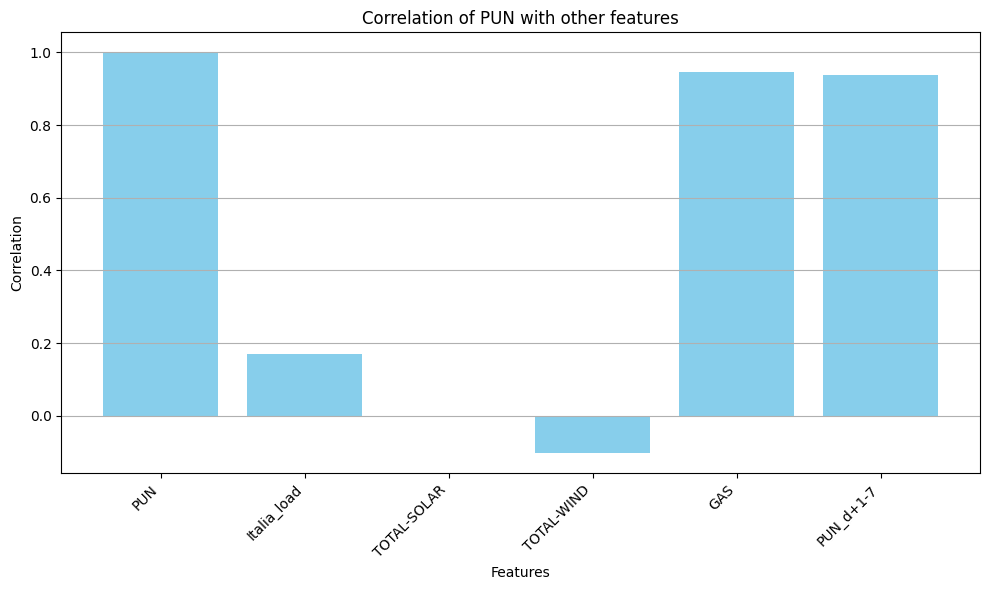

In [56]:
# Calcolare le correlazioni tra "PUN" e le altre features
pun_correlations = df_Italia.drop(columns=['Ora', 'GiornoSettimana', 'holiday']).corr()['PUN']

# Creare il plot
plt.figure(figsize=(10, 6))

# Plottare le correlazioni
plt.bar(pun_correlations.index, pun_correlations.values, color='skyblue')

# Aggiungere etichette
plt.title('Correlation of PUN with other features')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

plt.tight_layout()
plt.show()
